In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D, Diritchlet_Boundary_2D,Periodic_Boundary_2D

from local_utils import *

from intro import *
from scipy.optimize import minimize

import pandas as pd

In [158]:
import pickle
with open(f"./inputs/solution_25.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

In [159]:
def p(* args):
    plot_n_im(args, 
           [chr(ord('A') + i) for i in range(28)][:len(args)],          
        figsize=(12, 3)); plt.tight_layout();plt.show()

In [160]:
def create_F_A(A,B,C):
    def F_A(b_A, mu_A, V_A,
            K_AA, K_BA, n, **kwargs):
        fA_v = b_A + V_A * act(A, K_AA, n) * inh(B, K_BA, n) - mu_A * A        
        return fA_v
    return F_A
def create_F_B(A,B,C):
    def F_B(b_B, mu_B, V_B,
            K_AB, K_CB, n, **kwargs):
        fB_v = b_B + V_B * act(A, K_AB, n) * inh(C, K_CB, n) - mu_B * B
        return fB_v
    return F_B
def create_F_C(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = b_C + V_C * inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) - mu_C * C        
        return fC_v
    return F_C
def create_F_C_no_mu_c(A,B,C):
    def F_C(b_C,  V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = b_C + V_C * inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) - params["mu_C"] * C        
        return fC_v
    return F_C
def create_F_C_inv1(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = b_C/(mu_C + 1e-60) + (V_C/(mu_C + 1e-60)) * inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) -  C
        return fC_v
    return F_C

def create_F_C_inv2(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = 1 + (V_C/(b_C + 1e-60)) * inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) - (mu_C/(b_C + 1e-60)) * C
        return fC_v
    return F_C

def create_F_C_inv3(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n, **kwargs):
        fC_v = b_C/(V_C + 1e-60) + inh(A, K_AC, n) * inh(B, K_BC, n) * act(C, K_CC, n) - (mu_C/(V_C + 1e-60)) * C
        return fC_v
    return F_C

def create_param_kinetics(A,B,C):
    F_A = create_F_A(A,B,C)
    F_B = create_F_B(A,B,C)
    F_C = create_F_C(A,B,C)
    def circuit_3954(b_A, mu_A, V_A,
                     K_AA, K_AB, K_AC, 
                     b_B, mu_B, V_B, 
                     K_BA, K_BC, 
                     b_C, mu_C, V_C, 
                     K_CB, K_CC, n, **kwargs):
        fA_v = F_A(b_A, mu_A, V_A, K_AA, K_BA, n)
        fB_v = F_B(b_B, mu_B, V_B, K_AB, K_CB, n)
        fC_v = F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)
        return (fA_v, fB_v, fC_v)
    return circuit_3954

In [161]:
solution.shape

(301, 3, 128, 128)

In [148]:
# x_slice = y_slice = slice(1,-1,1)
# with open(f"./inputs/temp.pkl", "rb") as f:
#     (A_hat, B_hat, C_hat) = pickle.load(f)

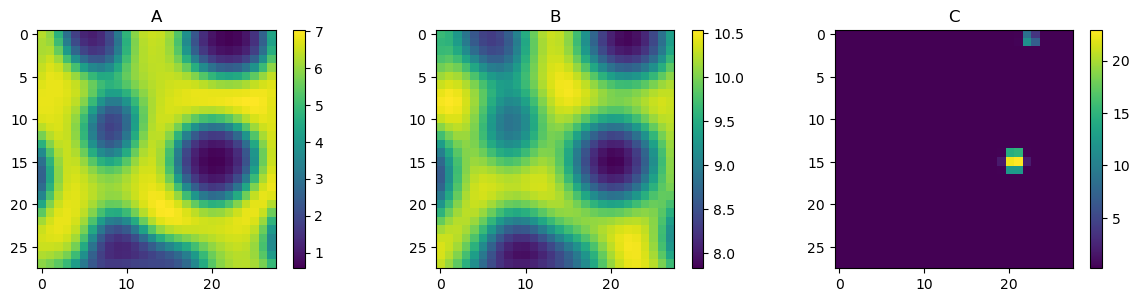

In [184]:
index = 20#5000#-2#200000-1#3000#5000-1
A_n = solution[index,0, :].reshape((128,128)).astype(np.float64)
B_n = solution[index,1, :].reshape((128,128)).astype(np.float64)
C_n = solution[index,2, :].reshape((128,128)).astype(np.float64)

A_n_1 = solution[index-1,0, :].reshape((128,128)).astype(np.float64)
B_n_1 = solution[index-1,1, :].reshape((128,128)).astype(np.float64)
C_n_1 = solution[index-1,2, :].reshape((128,128)).astype(np.float64)


x_slice = y_slice = slice(50,-50,1)
p(A_n[x_slice,y_slice], B_n[x_slice,y_slice], C_n[x_slice,y_slice])
# p(A_hat, B_hat, C_hat)
# p(A_n[x_slice,y_slice]-A_hat, 
#   B_n[x_slice,y_slice]-B_hat, 
#   C_n[x_slice,y_slice]-C_hat)

diff_c = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
diffusion_A_n = diff_c * grad_diff(A_n)[x_slice,y_slice]
diffusion_B_n = diff_c * grad_diff(B_n)[x_slice,y_slice]

# x_slice2 = y_slice2 = slice(1,-1,1)
# A_n = A_n[x_slice2,y_slice2]
# B_n = B_n[x_slice2,y_slice2]
# C_n = C_n[x_slice2,y_slice2]
# diffusion_A_n = diffusion_A_n[x_slice2,y_slice2]
# diffusion_B_n = diffusion_B_n[x_slice2,y_slice2]

# x_slice = y_slice = slice(1,-1,1)
# gamma =1.0
# A_n = (gamma*A_hat + 0*(1-gamma)*A_n[50:-50,50:-50])
# B_n = (gamma*B_hat + 0*(1-gamma)*B_n[50:-50,50:-50])
# C_n = (gamma*C_hat + 0*(1-gamma)*C_n[50:-50,50:-50])

# A_n = A_hat.astype(np.float64)
# B_n = B_hat.astype(np.float64)
# C_n = C_hat.astype(np.float64)

# diffusion_A_n = diffusion_A_n[x_slice,y_slice]
# diffusion_B_n = diffusion_B_n[x_slice,y_slice]


param_F_A = create_F_A(A_n, B_n, C_n)
param_F_B = create_F_B(A_n, B_n, C_n)
param_F_C = create_F_C(A_n, B_n, C_n)

param_F_C_no_mu_C = create_F_C_no_mu_c(A_n, B_n, C_n)


param_F_C_inv1 = create_F_C_inv1(A_n, B_n, C_n)
param_F_C_inv2 = create_F_C_inv2(A_n, B_n, C_n)
param_F_C_inv3 = create_F_C_inv3(A_n, B_n, C_n)

D_A, D_B, n = params["D_A"], params["D_B"],params["n"]

def time_der_A(b_A, mu_A, V_A,
               K_AA, K_BA, **kwargs):
    
    F_A = param_F_A(b_A, mu_A, V_A, K_AA, K_BA, n)
    dAdt = D_A*diffusion_A_n + F_A[x_slice,y_slice]    
    return dAdt

def time_der_B(b_B, mu_B, V_B,
               K_AB, K_CB, **kwargs):
    
    F_B = param_F_B(b_B, mu_B, V_B, K_AB, K_CB, n)
    dBdt = D_B*diffusion_B_n + F_B[x_slice,y_slice]    
    return dBdt

def time_der_C(b_C, mu_C, V_C,
               K_AC, K_BC, K_CC, **kwargs):
    
    dCdt = param_F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice] 
    return dCdt
def time_der_C_with_no_mu_c(b_C, V_C,
               K_AC, K_BC, K_CC, **kwargs):
    
    dCdt = param_F_C_no_mu_C(b_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice] 
    return dCdt
def time_der_C_with_inv(b_C, mu_C, V_C,
               K_AC, K_BC, K_CC, **kwargs):
    
    dCdt = param_F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice]
    dCdt_inv1 = param_F_C_inv1(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice]
    dCdt_inv2 = param_F_C_inv2(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice]
    dCdt_inv3 = param_F_C_inv3(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n)[x_slice,y_slice]
    return dCdt, dCdt_inv1, dCdt_inv2, dCdt_inv3

def time_derivatives(b_A, mu_A, V_A,
                     K_AA, K_AB, K_AC, 
                     b_B, mu_B, V_B, 
                     K_BA, K_BC, 
                     b_C, mu_C, V_C, 
                     K_CB, K_CC, **kwargs):
    
#     e = np.exp
#     F_A, F_B, F_C = param_kinetics(e(b_A), e(mu_A), e(V_A),
#                                    e(K_AA), e(K_AB), e(K_AC),
#                                    e(b_B), e(mu_B), e(V_B),
#                                    e(K_BA), e(K_BC),
#                                    e(b_C), e(mu_C), e(V_C), e(K_CB), e(K_CC), n)
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC)
    return dAdt, dBdt, dCdt

def loss_A(b_A, mu_A, V_A,K_AA, K_BA,  **kwargs):
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    return np.mean(dAdt**2)

def loss_B(b_B, mu_B, V_B,K_AB, K_CB,  **kwargs):
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    return np.mean(dBdt**2)

def loss_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC,  **kwargs):
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC)
    return np.mean(dCdt**2)

def loss(args,  **kwargs):
    (b_A, mu_A, V_A,
     K_AA, K_AB, K_AC, 
     b_B, mu_B, V_B, 
     K_BA, K_BC, 
     b_C, mu_C, V_C, 
     K_CB, K_CC) = args
    dAdt,dBdt,dCdt = time_derivatives(b_A, mu_A, V_A,K_AA, K_AB, K_AC,b_B, mu_B, V_B,K_BA, K_BC,
                                      b_C, mu_C, V_C, K_CB, K_CC)
    
    loss_A = np.mean(dAdt**2)
    loss_B = np.mean(dBdt**2)
    loss_C = np.mean(dCdt**2)
    return (loss_A + loss_B + loss_C)

def loss_no_mu_C(args,  **kwargs):
    (b_A, mu_A, V_A,
     K_AA, K_AB, K_AC, 
     b_B, mu_B, V_B, 
     K_BA, K_BC, 
     b_C, V_C, 
     K_CB, K_CC) = args
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    dCdt = time_der_C_with_no_mu_c(b_C, V_C, K_AC, K_BC, K_CC)
    loss_A = np.mean(dAdt**2)
    loss_B = np.mean(dBdt**2)
    loss_C = np.mean(dCdt**2)
    return (loss_A + loss_B + loss_C)

    return (loss_A + loss_B + loss_C)

def loss_with_invs(args,  **kwargs):
    (b_A, mu_A, V_A,
     K_AA, K_AB, K_AC, 
     b_B, mu_B, V_B, 
     K_BA, K_BC, 
     b_C, mu_C, V_C, 
     K_CB, K_CC) = args
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB)
    dCdt, dCdt_inv1, dCdt_inv2, dCdt_inv3 = time_der_C_with_inv(b_C, mu_C, V_C, K_AC, K_BC, K_CC)
    loss_A = np.mean(dAdt**2)
    loss_B = np.mean(dBdt**2)
    loss_C = np.mean(dCdt**2)+np.mean(dCdt_inv1**2)+np.mean(dCdt_inv2**2)+np.mean(dCdt_inv3**2)
    return (loss_A + loss_B + loss_C)

params_A_name_list = ["b_A", "mu_A", "V_A","K_AA", "K_BA"]
params_B_name_list = ["b_B", "mu_B", "V_B","K_AB", "K_CB"]
params_C_name_list = ["b_C", "mu_C", "V_C","K_AC", "K_BC", "K_CC"]
params_name_list = ["b_A", "mu_A", "V_A","K_AA", "K_AB", "K_AC","b_B", "mu_B", "V_B","K_BA", "K_BC",
                    "b_C", "mu_C", "V_C", "K_CB", "K_CC"]

params_name_list_no_mu_C = ["b_A", "mu_A", "V_A","K_AA", "K_AB", "K_AC","b_B", "mu_B", "V_B","K_BA", "K_BC",
                    "b_C", "V_C", "K_CB", "K_CC"]

1.195625003671324
12.132323390647453
0.15044037542984812 0.07303334556808924 1.1838720257188748
0.15044037542984812 0.07303334556808924 1.1838720257188748
0.022632306559473646 0.00533386956486794 1.401552973279712


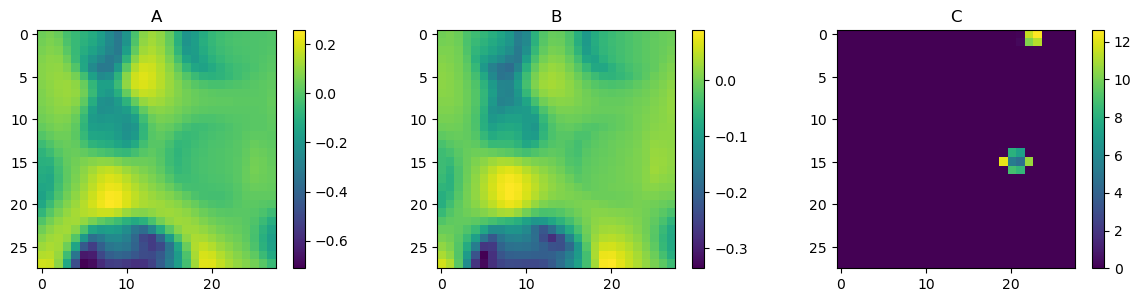

In [185]:
params_list = [params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_AB, params.K_AC, 
               params.b_B, params.mu_B, params.V_B, params.K_BA, params.K_BC, 
               params.b_C, params.mu_C, params.V_C, params.K_CB, params.K_CC]
# params_log = [np.log(l) for l in params_list]
# print(np.sqrt(loss(params_log)))

# a,b,c = time_derivatives(*params_log)
# print(np.sqrt(np.mean(a**2)),np.sqrt(np.mean(b**2)),np.sqrt(np.mean(c**2)))
# p(a,b,c)

print(np.sqrt(loss(params_list)))
print(np.sqrt(loss_with_invs(params_list)))
a,b,c = time_derivatives(*params_list)
print(np.sqrt(np.mean(a**2)),np.sqrt(np.mean(b**2)),np.sqrt(np.mean(c**2)))

# 0.008260324969748052
#0.0001398658536897556, 6.759127670819233e-05, 0.008258864181479664
a2 = loss_A(params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_BA)
b2 = loss_B(params.b_B, params.mu_B, params.V_B, params.K_AB, params.K_CB)
c2 = loss_C(params.b_C, params.mu_C, params.V_C, params.K_AC, params.K_BC, params.K_CC)
print(np.sqrt(a2),np.sqrt(b2),np.sqrt(c2))

print(a2,b2,c2)

p(a,b,c)


In [186]:
A_min, A_max = np.min(A_n), np.max(A_n)
B_min, B_max = np.min(B_n), np.max(B_n)
C_min, C_max = np.min(C_n), np.max(C_n)
tol = .01

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)

In [187]:
K_CB_bound, K_CB_init, K_CC_bound, K_CC_init

((0.06340908414092337, 99.4821765678769),
 49.70938374186799,
 (0.06340908414092337, 99.4821765678769),
 49.70938374186799)

In [188]:

i = 0
def print_callback(x):
    global i
    
    if (i+1)%100 == 0 or i == 0:
        print(f"iteration:{i+1}, loss: {loss_no_mu_C(x):.8f} ", 
          f", ".join([f"{name}={l:.4f}" 
                 for l, name in zip(x, params_name_list_no_mu_C)]))
    i += 1
    
# init_params = [params.b_A, params.mu_A, params.V_A, params.K_AA, params.K_AB, params.K_AC, 
#                params.b_B, params.mu_B, params.V_B, params.K_BA, params.K_BC, 
#                params.b_C, params.mu_C, params.V_C, params.K_CB, params.K_CC]
init_params = [1, 1, 1, K_AA_init, K_AB_init, K_AC_init, 
               1, 1, 1, K_BA_init, K_BC_init, 
               1, 1,  K_CB_init, K_CC_init]


bounds = [ (0, None) for _ in init_params]
# bounds = [ (0, None), (0, None), (0, None), K_AA_bound, K_AC_bound, K_AC_bound,
#            (0, None), (0, None), (0, None), K_BA_bound, K_BC_bound,
#            (0, None), (0, None), K_CB_bound, K_CC_bound]
res = minimize(loss_no_mu_C, init_params, bounds=bounds, tol=1e-16,
               options={'maxiter':1e4, 'maxfun':1e6},
               method="L-BFGS-B",#"Powell",#"Nelder-Mead",# 
               callback=print_callback)
estimated_params = dict()
for l, name in zip(res.x, params_name_list_no_mu_C):    
    estimated_params[name] = l#np.exp(l)


iteration:1, loss: 758.93497338  b_A=1.3880, mu_A=0.9495, V_A=1.0249, K_AA=11.5641, K_AB=11.5267, K_AC=11.5720, b_B=1.9046, mu_B=0.9495, V_B=1.1440, K_BA=15.6424, K_BC=15.6415, b_C=0.9495, V_C=1.0001, K_CB=49.7094, K_CC=49.7094
iteration:100, loss: 0.65856754  b_A=0.0000, mu_A=0.8550, V_A=11.4269, K_AA=4.7711, K_AB=4.9953, K_AC=11.5720, b_B=0.7250, mu_B=5.0598, V_B=99.8435, K_BA=12.4721, K_BC=15.6933, b_C=0.2301, V_C=3.4035, K_CB=49.7093, K_CC=49.4456
iteration:200, loss: 0.44055838  b_A=0.0302, mu_A=1.0100, V_A=153.9211, K_AA=5.3392, K_AB=4.9826, K_AC=11.5724, b_B=7.2202, mu_B=5.8300, V_B=101.5079, K_BA=5.2395, K_BC=17.7905, b_C=0.0251, V_C=53.7031, K_CB=49.7084, K_CC=38.5135
iteration:300, loss: 0.20301850  b_A=0.0000, mu_A=0.8396, V_A=192.8102, K_AA=5.5445, K_AB=4.9973, K_AC=11.5726, b_B=0.5072, mu_B=5.0401, V_B=99.9359, K_BA=4.8096, K_BC=18.5135, b_C=0.1401, V_C=66.9031, K_CB=49.7079, K_CC=31.9339
iteration:400, loss: 0.20191843  b_A=0.0000, mu_A=0.8466, V_A=176.9569, K_AA=5.5379, 

iteration:3600, loss: 0.02979870  b_A=0.0000, mu_A=0.8979, V_A=26.7858, K_AA=5.1211, K_AB=4.9968, K_AC=10.5050, b_B=0.7625, mu_B=5.0704, V_B=99.9951, K_BA=8.5373, K_BC=3.4319, b_C=0.1079, V_C=315.8396, K_CB=48.8081, K_CC=11.1964
iteration:3700, loss: 0.02979108  b_A=0.0000, mu_A=0.8967, V_A=26.8243, K_AA=5.1223, K_AB=4.9967, K_AC=10.1693, b_B=0.7278, mu_B=5.0663, V_B=99.9827, K_BA=8.5295, K_BC=3.2045, b_C=0.1076, V_C=412.3252, K_CB=48.5263, K_CC=11.2066
iteration:3800, loss: 0.02977929  b_A=0.0000, mu_A=0.8981, V_A=26.9354, K_AA=5.1229, K_AB=4.9968, K_AC=9.1404, b_B=0.7219, mu_B=5.0656, V_B=99.9851, K_BA=8.5213, K_BC=2.7906, b_C=0.1078, V_C=708.1249, K_CB=47.6624, K_CC=11.1953
iteration:3900, loss: 0.02977603  b_A=0.0000, mu_A=0.8977, V_A=26.9670, K_AA=5.1233, K_AB=4.9968, K_AC=8.3411, b_B=0.7027, mu_B=5.0633, V_B=99.9790, K_BA=8.5165, K_BC=2.5996, b_C=0.1080, V_C=937.7842, K_CB=46.9915, K_CC=11.2071
iteration:4000, loss: 0.02977380  b_A=0.0000, mu_A=0.8976, V_A=26.9675, K_AA=5.1237, K

In [189]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.026007601842793902
        x: [ 0.000e+00  8.977e-01 ...  4.875e+01  9.942e+00]
      nit: 5052
      jac: [ 1.800e-03  1.597e-06 ...  6.696e-08 -1.068e-06]
     nfev: 94224
     njev: 5889
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>

In [190]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]

print("name \tOriginl \tEstimated \tClosest Bound \tBounds")# \tEstimated (Unbounded)")
print("------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"                  
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
                 #f"{estimated_params_unbound[name]:.3f}\t\t"
      for name in params_name_list_no_mu_C
]))

name 	Originl 	Estimated 	Closest Bound 	Bounds
------------------------------------------------------------------------------
b_A:	0.001		0.000		nan		(nan,nan)
mu_A:	1.000		0.898		nan		(nan,nan)
V_A:	20.000		26.894		nan		(nan,nan)
K_AA:	5.000		5.123		0.139		(0.139,23.283)
K_AB:	5.000		4.997		0.139		(0.139,23.283)
K_AC:	1.000		0.741		0.139		(0.139,23.283)
b_B:	0.100		0.731		nan		(nan,nan)
mu_B:	5.000		5.067		nan		(nan,nan)
V_B:	100.000		99.986		nan		(nan,nan)
K_BA:	10.000		8.525		2.378		(2.378,33.661)
K_BC:	10.000		3.699		2.378		(2.378,33.661)
b_C:	0.100		0.107		nan		(nan,nan)
V_C:	25.000		332.904		nan		(nan,nan)
K_CB:	10.000		48.753		0.063		(0.063,99.482)
K_CC:	1.000		9.942		0.063		(0.063,99.482)


In [ ]:
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D

D_A, D_B , n, mu_C= 0.01, 1.0, 4, params["mu_C"]
model_integrator = RD_2D_1st_Order(Ds=[D_A, D_B, 0], 
                        delta_t=100/5000, 
                        Lx=10, Ly=10, 
                        Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D)

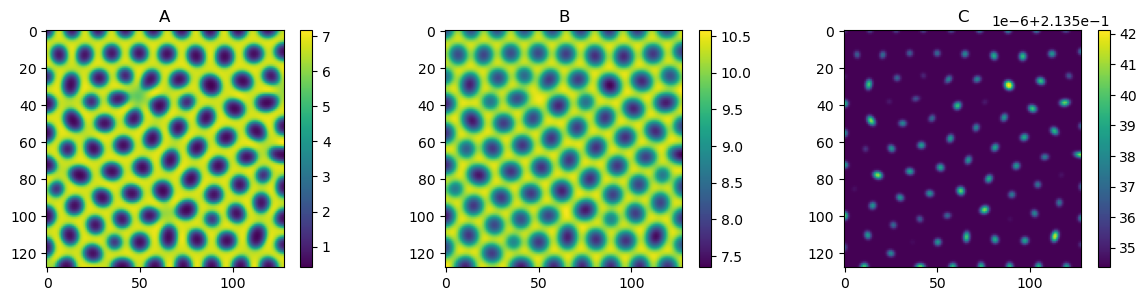

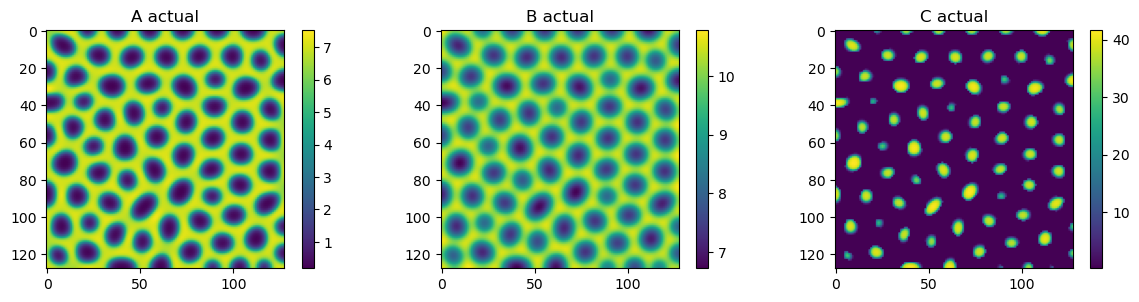

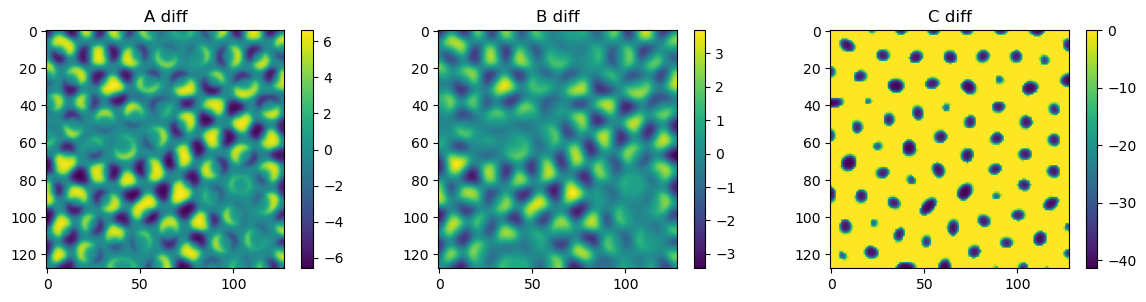

In [169]:

params2 = {}
for k,v in estimated_params.items():
    if not k.startswith("K"):
        params2[k] = v
    else:
        lower, upper = Ks_bounds[k]
        if v < lower:
            params2[k] = lower
        elif v > upper:
            params2[k] = upper
        else:
            params2[k] = v

kinetics = create_circuit_3954(n,params2["b_A"], params2["mu_A"], params2["V_A"], 
                                       params2["K_AA"], params2["K_AB"], params2["K_AC"],
                                       params2["b_B"], params2["mu_B"], params2["V_B"], 
                                       params2["K_BA"], params2["K_BC"],
                                       params2["b_C"], mu_C, params2["V_C"], 
                                       params2["K_CB"], params2["K_CC"])

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model_integrator.integrate([A_init, B_init, C_init],kinetics, 4*5000, record_steps=5000)

A_test = solution_test[-1,0, :].reshape((128,128))
B_test = solution_test[-1,1, :].reshape((128,128))
C_test = solution_test[-1,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([solution[105, 0, :, :],solution[105, 1, :, :],solution[105, 2, :, :]], 
           ["A actual","B actual","C actual"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([A_test-solution[105, 0, :, :],
           B_test-solution[105, 1, :, :],
           C_test-solution[105, 2, :, :]], 
           ["A diff","B diff","C diff"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 